# 1. Multi-task Learning
Multi-task learning means using one model, here using one neural network we will do simultaneously several tasks.

![jupyter](https://cdn-images-1.medium.com/max/2560/1*rrIJOpJO8fkFECNHlwq-jQ.png)

The issue of self-driving car: Y={Pedestrian, Car, Stop Sign, Traffic Light}, which  corresponds to the output vector as a vector, e.g., [0, 1, 1, 0].

![jupyter](https://cdn-images-1.medium.com/max/1200/1*RXWO8pWJelvFJrGEr8sRrg.png)

In [1]:
# adjust cell width
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>")) 

# 1.1 Dataset

- 2000 images with natural scene
- each image could be one of these classes: <b>(desert, mountains, sea, sunset and trees)</b>


In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

from sklearn.model_selection import train_test_split


In [2]:
def load():
    f = h5py.File("./data/dataset.h5")
    x = f['x'].value
    y = f['y'].value
    f.close()
    
    x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=100)
    
    # Making the data channel last
    x_train = np.rollaxis(x_train, 1, 4)
    x_test = np.rollaxis(x_test, 1, 4)
    
    # Normalizing data
    ########################
    ##   Input code here  ##
    ########################
    x_train = x_train  / 255.0
    x_test = x_test / 255.0
   
    return x_train, x_test, y_train, y_test

/home/dp1/.conda/envs/tensorflow/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


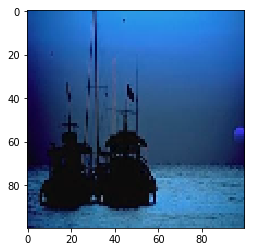

In [3]:
x_train, x_test, y_train, y_test = load()
plt.imshow(x_train[0])

In [4]:
class_names = ['desert', 'mountains', 'sea', 'sunset','trees'] 


## 1.2 Explore the data 

In [5]:
def getLabels(y):
    labels = []
    for i in range(len(y)):
        if y[i] == 1:
            labels.append(class_names[i])
        else:
            labels.append(0)
    return labels

In [6]:
getLabels(y_train[1])

[0, 0, 'sea', 0, 0]

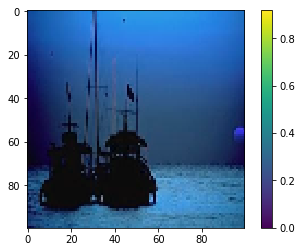

In [7]:
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

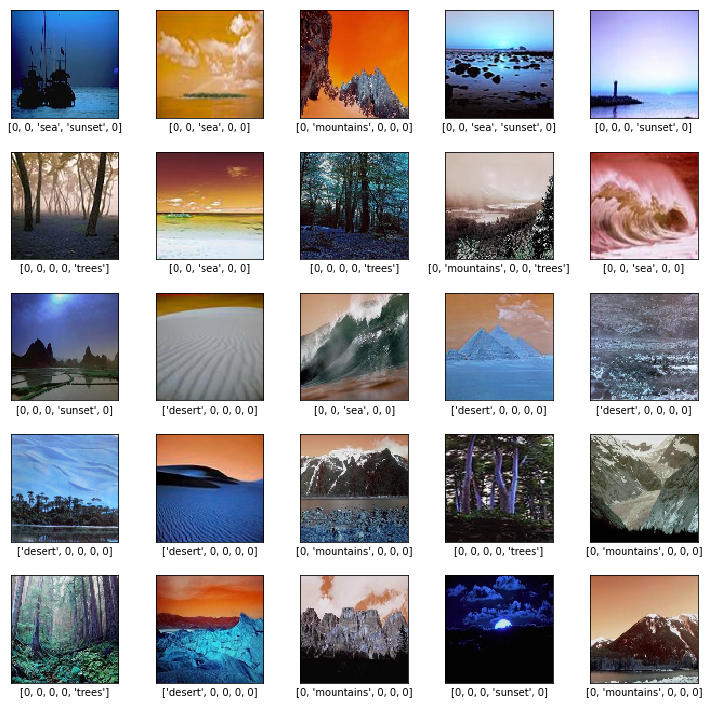

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(getLabels(y_train[i]))
plt.show()

In [9]:
x_train.shape
# (1600, 100, 100, 3)

(1600, 100, 100, 3)

# Implementation of Multi-task Loss Function


$-\frac{1}{m}\sum_{i=1}^m \sum_{j=1}^k (y_i^{(j)} log\hat{y}_i^{(j)} + (1-y_i^{(j)})log(1-\hat{y}_i^{(j)})$

In this example, the classes are desert, mountains, sea, sunset and trees.

In [10]:
import tensorflow.keras.backend as K

In [11]:
def multitask_loss(y_true, y_pred):
    # Avoid divide by 0
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # Multi-task loss
    return K.mean(K.sum(- y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred), axis=1))


# 2. CNN Model

## 2.1 build model 

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation

In [13]:
# initialize

batch_size = 100
num_classes = 5
epochs = 5

# input image dimensions
img_rows, img_cols = 100, 100
channels = 3


In [14]:
# CNN
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),padding='same',input_shape=(img_rows, img_cols, channels)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## 2.2 model compile and fit 

In [15]:
model.compile(loss=multitask_loss,
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
%%time
hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 1600 samples, validate on 400 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
1600/1600 [==============================] - 42s 26ms/sample - loss: 2.7926 - acc: 0.3069 - val_loss: 2.4158 - val_acc: 0.4375
Epoch 2/5
1600/1600 [==============================] - 48s 30ms/sample - loss: 2.2808 - acc: 0.4263 - val_loss: 2.2415 - val_acc: 0.4925
Epoch 3/5
1600/1600 [==============================] - 47s 30ms/sample - loss: 2.0397 - acc: 0.5400 - val_loss: 1.9904 - val_acc: 0.5625
Epoch 4/5
1600/1600 [==============================] - 48s 30ms/sample - loss: 1.8833 - acc: 0.5731 - val_loss: 1.8890 - val_acc: 0.6275
Epoch 5/5
1600/1600 [==============================] - 48s 30ms/sample - loss: 1.7999 - acc: 0.5987 - val_loss: 1.8198 - val_acc: 0.6275
CPU times: user 19min 17s, sys: 2min 19s, total: 21min 37s
Wall time: 3min 53s


In [ ]:
print(hist.history.keys())

## 2.3 visualization

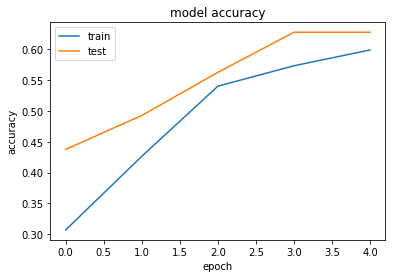

In [19]:
# summarize history for accuracy
plt.figure()
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

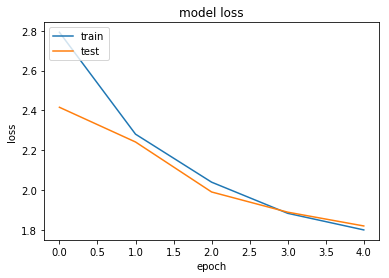

In [20]:
# summarize history for loss value
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 2.4 Inference

In [16]:
def infer(input_data, model=model):
    inference = []
    
    classes = np.array(['desert', 'mountain', 'sea', 'sunset', 'trees'])
    input_data = np.expand_dims(input_data, axis=0)
    y_pred = model.predict(input_data)
    
    # Performing masking
    y_pred = (y_pred > 0.5) * 1.0
    
    infer = getLabels(y_pred[0])
    
#     for i in range(y_pred.shape[0]):
#         # select the indices
#         indices = np.where(y_pred[i] == 1.0)[0]
#         # Adding the results 
#         inference.append(classes[indices].tolist())
        
    return infer

In [26]:
def inferAll(input_data, model=model):
    inference = []
    
    classes = np.array(['desert', 'mountain', 'sea', 'sunset', 'trees'])
    y_pred = model.predict(input_data)
    
    # Performing masking
    y_pred = (y_pred > 0.5) * 1.0
    infer = []
    for y in y_pred:
        infer.append(getLabels(y))
    
#     for i in range(y_pred.shape[0]):
#         # select the indices
#         indices = np.where(y_pred[i] == 1.0)[0]
#         # Adding the results 
#         inference.append(classes[indices].tolist())
        
    return infer

In [17]:
i = 99
infer(x_test[99], model=model)

['desert', 'mountains', 0, 'sunset', 0]

In [19]:
########## wrong
print(x_train.shape)

(1600, 100, 100, 3)


In [24]:
pred = model.predict(x_test)

In [25]:
pred[1]

array([0.49070182, 0.55153966, 0.44703466, 0.49798876, 0.49851492],
      dtype=float32)

In [ ]:
in

In [ ]:
getLabels(y_pred[0])

In [28]:
___infer = inferAll(x_train, model=model)

In [30]:
___infer

[['desert', 'mountains', 0, 'sunset', 'trees'],
 ['desert', 'mountains', 0, 0, 0],
 ['desert', 'mountains', 0, 'sunset', 0],
 ['desert', 'mountains', 0, 'sunset', 'trees'],
 ['desert', 'mountains', 0, 'sunset', 0],
 ['desert', 'mountains', 0, 0, 0],
 ['desert', 'mountains', 0, 'sunset', 0],
 ['desert', 'mountains', 0, 0, 'trees'],
 ['desert', 'mountains', 0, 0, 0],
 ['desert', 'mountains', 0, 'sunset', 0],
 ['desert', 'mountains', 0, 0, 0],
 ['desert', 'mountains', 0, 0, 0],
 ['desert', 'mountains', 0, 'sunset', 'trees'],
 ['desert', 'mountains', 0, 'sunset', 0],
 ['desert', 'mountains', 0, 'sunset', 0],
 ['desert', 'mountains', 0, 'sunset', 0],
 ['desert', 'mountains', 0, 'sunset', 0],
 ['desert', 'mountains', 0, 'sunset', 0],
 [0, 'mountains', 0, 0, 'trees'],
 [0, 'mountains', 0, 'sunset', 0],
 [0, 'mountains', 0, 'sunset', 0],
 [0, 'mountains', 0, 'sunset', 0],
 ['desert', 'mountains', 0, 'sunset', 'trees'],
 ['desert', 'mountains', 0, 0, 0],
 ['desert', 'mountains', 0, 0, 0],
 ['de

In [23]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)
    caption = "True label: {}".format(getLabels(true_label))
    plt.xlabel(caption)

In [24]:
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(5), predictions_array, color="#777777")
    plt.ylim([0, 1])
    caption = ''
    for i in range(5):
        caption = caption + "{} {:2.0f}% -- ".format(class_names[i],
                                100*np.max(predictions_array[i]),
                                )
    plt.xlabel(caption)
    
#     predicted_label = np.argmax(predictions_array)

#     thisplot[predicted_label].set_color('red')
#     thisplot[true_label[0]].set_color('blue')


In [25]:
predictions = model.predict(x_test)

In [26]:
predictions[4]

array([0.48241773, 0.3526256 , 0.22014889, 0.07073399, 0.10591355],
      dtype=float32)

Model predictions: [0.1624007  0.0394375  0.4694338  0.84933925 0.07352224]
True labels: [0, 0, 'sea', 0, 0]


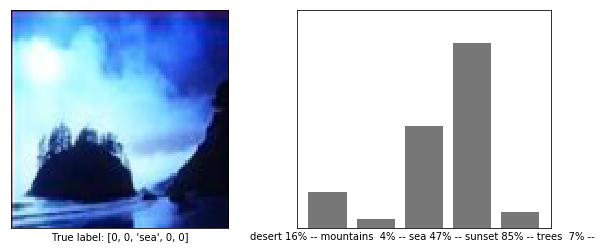

In [27]:
i = 2
print("Model predictions: {}".format(predictions[i]))
print("True labels: {}".format(getLabels(y_test[i])))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_image(i, predictions,y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  y_test)
plt.show()

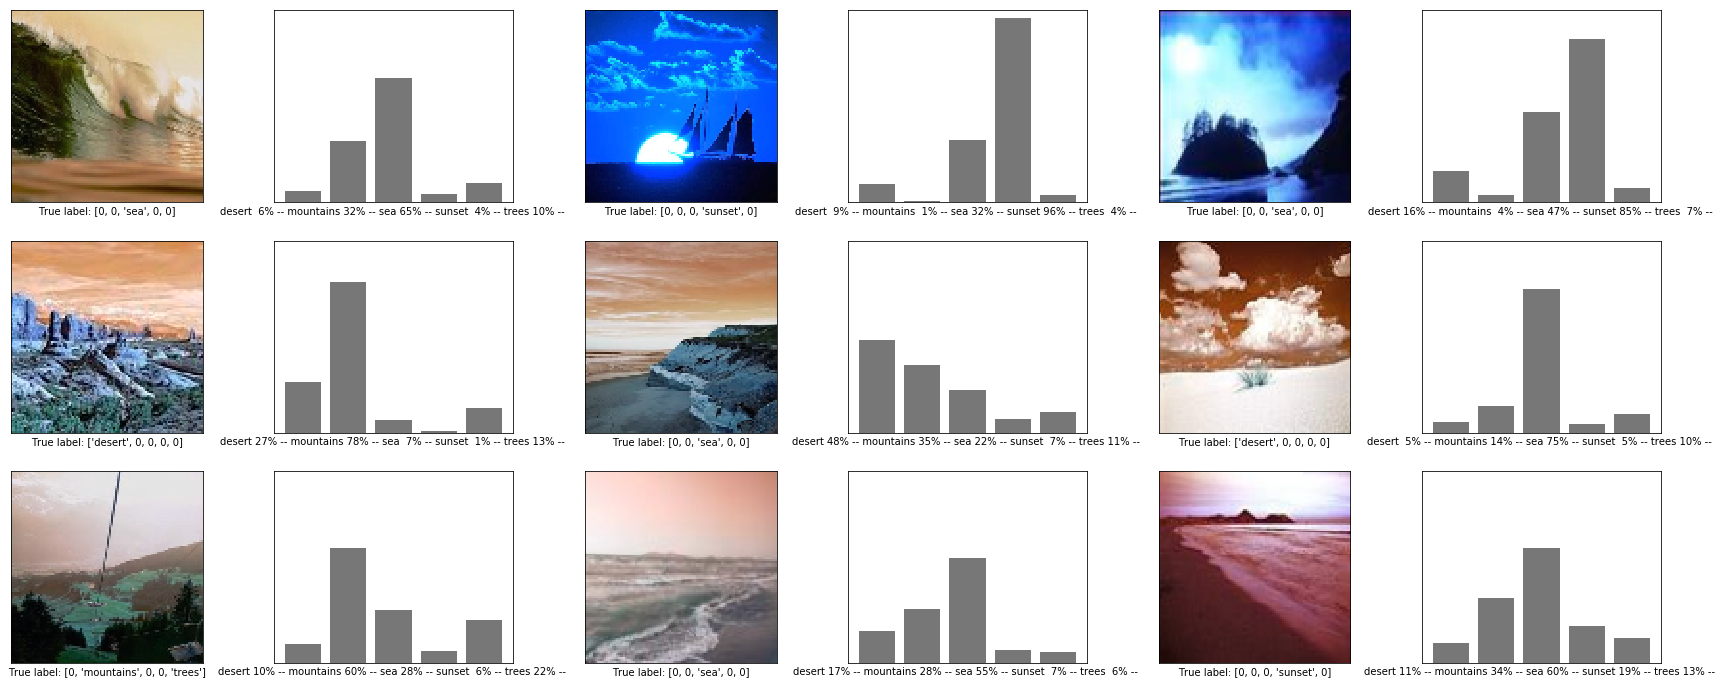

In [28]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*5*num_cols, 4*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, y_test, x_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, y_test)
plt.show()